# Exercise 5

In [2]:
import cv2
import os
import numpy as np
from util_functions import (
    Pi,
    PiInv,
    camera_intrinsic,
    projection_matrix,
    project_points,
    triangulate,
    checkerboard_points,
    calibrate_camera,
)
from matplotlib import pyplot as plt

In [3]:
# Ex 5.1
K = camera_intrinsic(700, (600, 400))
t1 = np.array([[0, 0, 1]]).T
t2 = np.array([[0, 0, 20]]).T
P1 = projection_matrix(K, np.eye(3), t1)
P2 = projection_matrix(K, np.eye(3), t2)
print(f"P1:\n{P1}")
print(f"P2:\n{P2}")

P1:
[[700.   0. 600. 600.]
 [  0. 700. 400. 400.]
 [  0.   0.   1.   1.]]
P2:
[[7.0e+02 0.0e+00 6.0e+02 1.2e+04]
 [0.0e+00 7.0e+02 4.0e+02 8.0e+03]
 [0.0e+00 0.0e+00 1.0e+00 2.0e+01]]


In [4]:
Q = np.array([[1, 1, 0]]).T
q1 = Pi(P1 @ PiInv(Q))
q2 = Pi(P2 @ PiInv(Q))
print(f"q1:\n{q1}")
print(f"q2:\n{q2}")

q1:
[[1300.]
 [1100.]]
q2:
[[635.]
 [435.]]


In [5]:
# Same results using project_points().
q1 = project_points(K, np.eye(3), t1, Q)
q2 = project_points(K, np.eye(3), t2, Q)
print(f"q1:\n{q1}")
print(f"q2:\n{q2}")

q1:
[[1300.]
 [1100.]]
q2:
[[635.]
 [435.]]


In [6]:
# Ex 5.2
# Add errors to projections to simulate noise
q1_til = q1 + np.array([[1, -1]]).T
q2_til = q2 + np.array([[1, -1]]).T

Q_til = triangulate([q1_til, q2_til], [P1, P2])
print(f"Q_til:\n{Q_til}")  # close to Q

# Find error between Q and Q_til
error = np.sqrt(np.sum((Q - Q_til) ** 2))
print(f"Error: {error}")

Q_til:
[[1.01527507e+00]
 [9.85270570e-01]
 [2.85786810e-04]]
Error: 0.021221817353380967


In [7]:
# Ex 5.3
# Triangulation using non-linear optimization


def triangulate_nonlin(q_list, P_list):
    """
    Nonlienar triangulation of a single 3D point seen by n cameras.

    Args:
        q_list : nx2x1 list of 2x1 pixel points
        P_list : nx3x4, list of 3x4 camera projection matrices

    Returns:
        Q : 3x1 vector, 3D point
    """

    def compute_residuals(Q):
        """
        Helper function.

        Args:
            Q : 3-vector, 3D point (parameters to optimize)

        Returns:
            residuals : 2n-vector, residuals
                        (numbers to minimize sum of squares)
        """
        Q = Q.reshape(-1, 1)
        Qh = PiInv(Q)
        residuals = np.zeros(2 * len(q_list))
        # Compute difference in projection
        for i, q in enumerate(q_list):
            projected_2D = Pi(P_list[i] @ Qh)
            res = (q - projected_2D).reshape(
                -1
            )  # least_squares() expects 1D array
            residuals[2 * i : 2 * (i + 1)] = res
        return residuals

    # Initial guess
    x0 = triangulate(q_list, P_list)  # 3x1
    x0 = x0.reshape(-1)  # least_squares() expects 1D array

    # Least squares optimization
    from scipy.optimize import least_squares

    result = least_squares(compute_residuals, x0)
    return result.x

In [8]:
# Ex 5.4
# using triangulate_nonlin()
Q_til_nonlin = triangulate_nonlin([q1_til, q2_til], [P1, P2])
Q_til_nonlin = Q_til_nonlin.reshape(-1, 1)
print(f"Q_til_nonlin:\n{Q_til_nonlin}")  # close to Q

# Compute error
error_nonlin = np.sqrt(np.sum((Q - Q_til_nonlin) ** 2))
print(f"Error non-linear: {error_nonlin}")

Q_til_nonlin:
[[1.00153897e+00]
 [9.98546320e-01]
 [4.27473316e-05]]
Error non-linear: 0.0021174151996546527


In [9]:
# Ex 5.6
# Load images
folder_path = "media/checker"
images = []
img_names = []

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Read the image and append it to the list
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        # Check correct landscape orientation for my phone
        if image.shape != (720, 1280, 3):
            print(f"Image {filename} has wrong shape: {image.shape}")
        images.append(image)
        img_names.append(filename)

# Print the list of images
print(f"{len(images)} images have been loaded.")

24 images have been loaded.


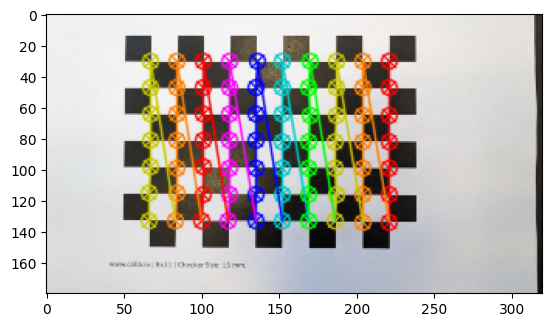

In [10]:
# Ex 5.7
# Check quality of images

# Test findChessboardCorners() on an 'easy' image
top_view_path = "media/checker/top.jpg"
top_view = cv2.imread(top_view_path)
im_small = cv2.resize(top_view, None, fx=0.25, fy=0.25)

out = cv2.findChessboardCorners(im_small, (7, 10))  # size: no. internal corners

# Draw the corners
im_corners = im_small.copy()
cv2.drawChessboardCorners(im_corners, (7, 10), out[1], out[0])

# cv2.imshow() crashes in Jupyter
%matplotlib inline
plt.imshow(cv2.cvtColor(im_corners, cv2.COLOR_BGR2RGB))

Failed to find corners in photo_13_2024-03-01_15-37-16.jpg
Failed to find corners in photo_17_2024-03-01_15-37-16.jpg
Failed to find corners in photo_6_2024-03-01_15-37-16.jpg
Failed to find corners in photo_9_2024-03-01_15-37-16.jpg


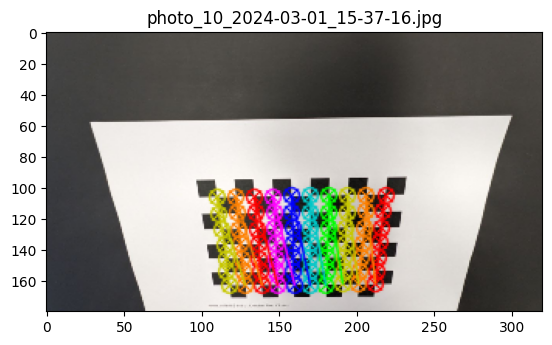

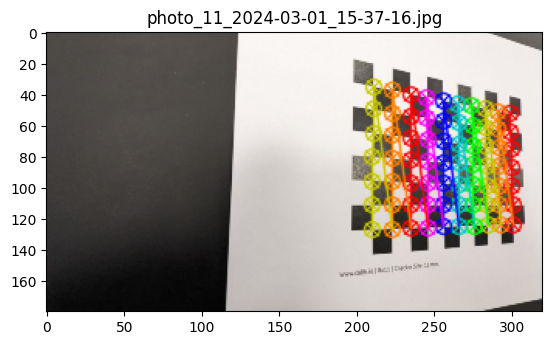

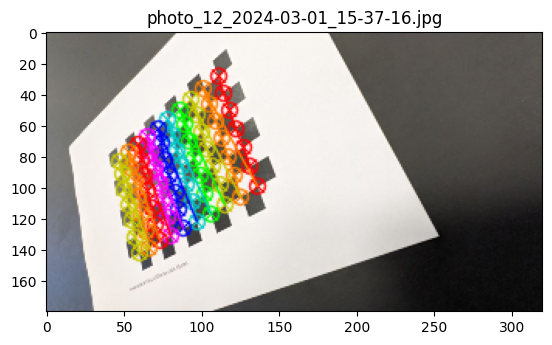

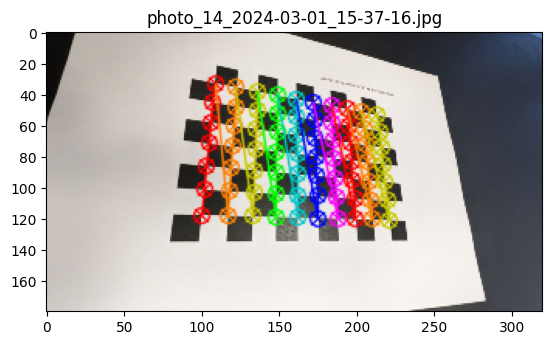

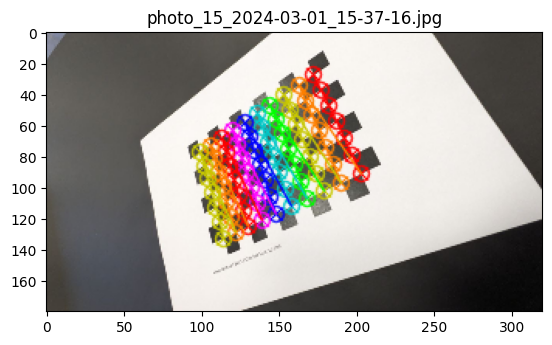

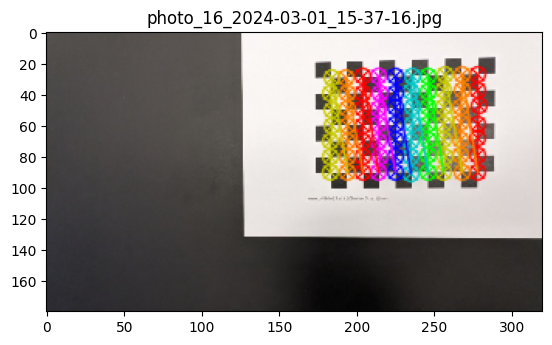

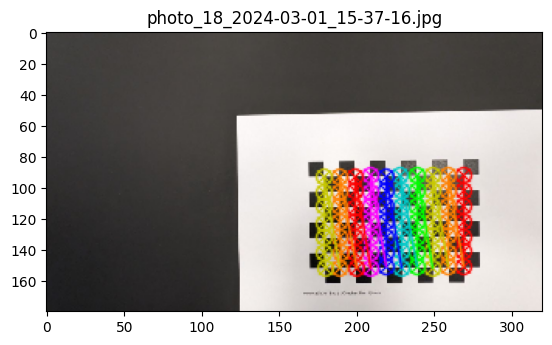

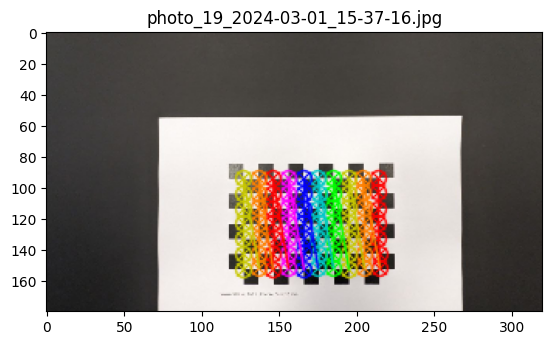

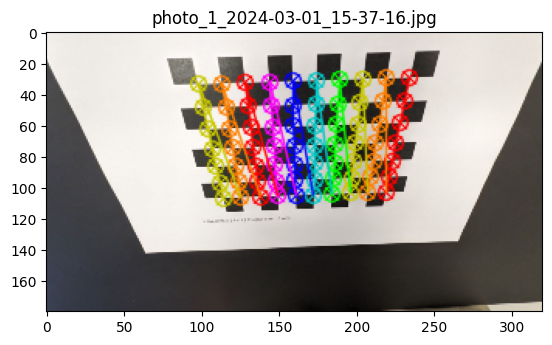

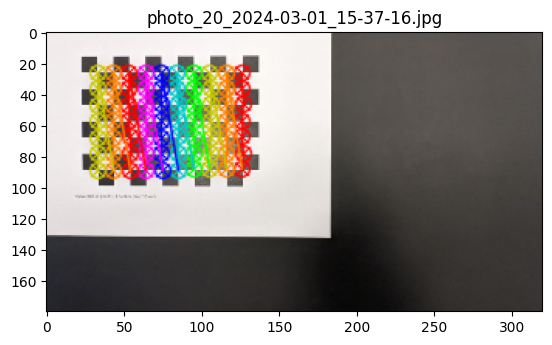

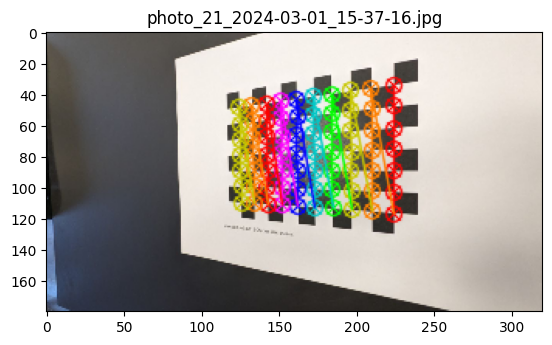

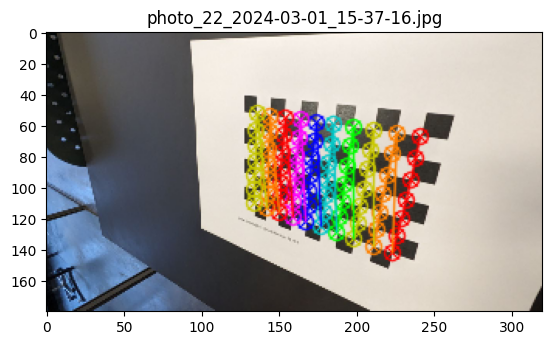

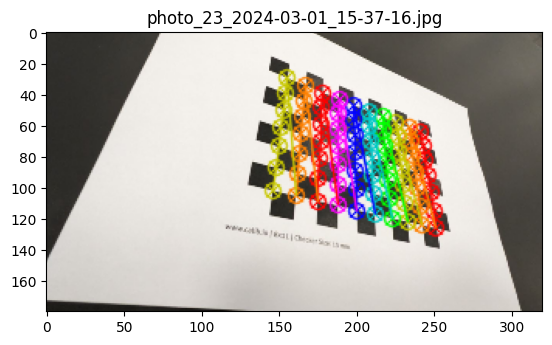

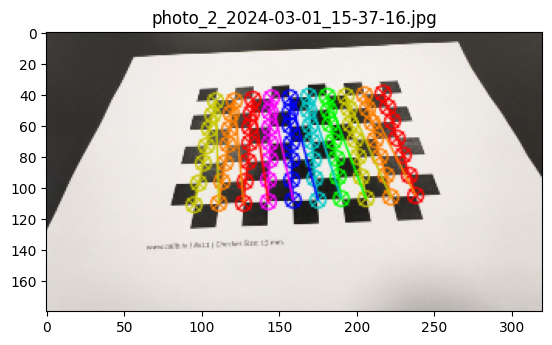

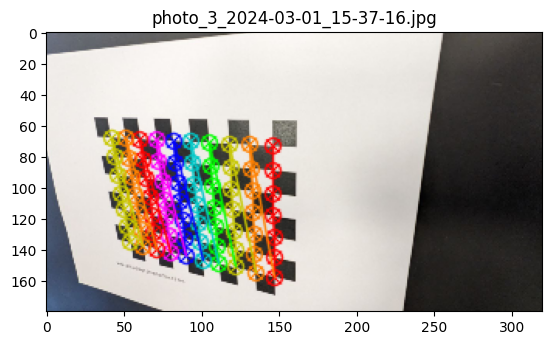

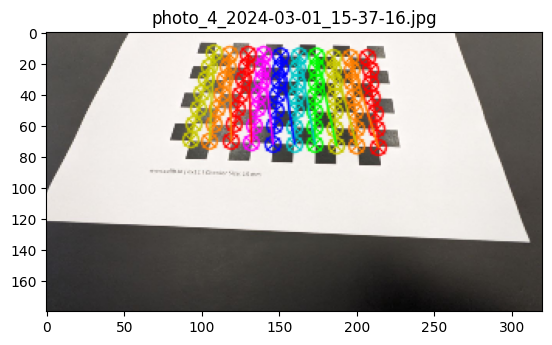

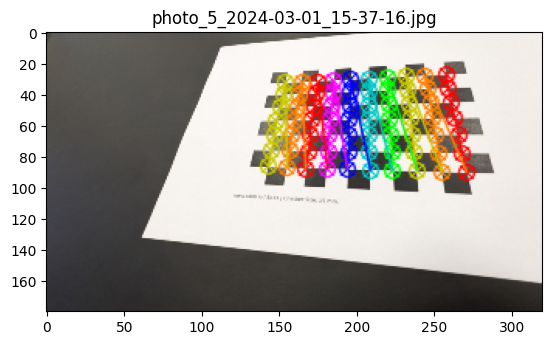

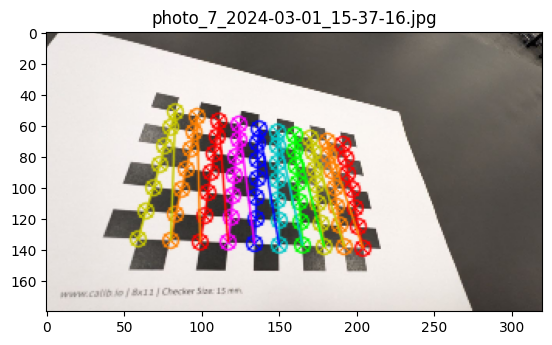

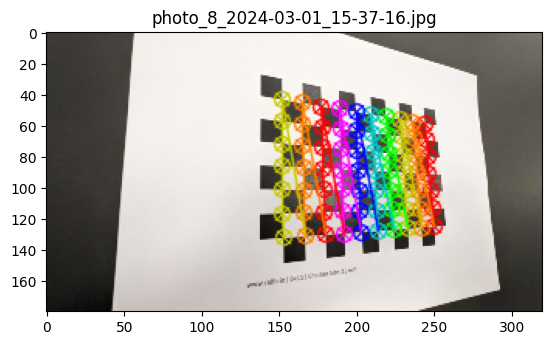

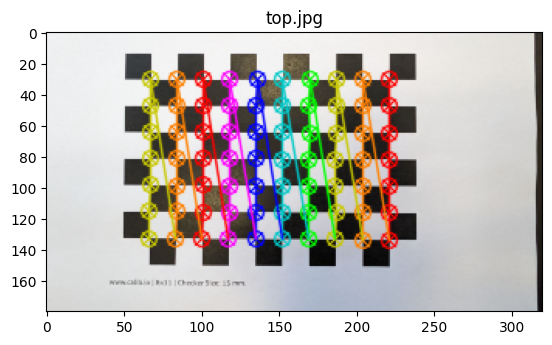

In [11]:
# Run findChessboardCorners() on all images
passed_idx = []
for i, im in enumerate(images):
    im_small = cv2.resize(im, None, fx=0.25, fy=0.25)
    out = cv2.findChessboardCorners(im_small, (7, 10))

    if out != (False, None):
        passed_idx.append(i)
    else:
        print(f"Failed to find corners in {img_names[i]}")
        continue
    # Draw the corners
    im_corners = im_small.copy()
    cv2.drawChessboardCorners(im_corners, (7, 10), out[1], out[0])

    # cv2.imshow() crashes in Jupyter
    %matplotlib inline
    plt.figure()
    plt.title(img_names[i])
    plt.imshow(cv2.cvtColor(im_corners, cv2.COLOR_BGR2RGB))

In [12]:
# Ex 5.8
# Calibrate camera using the images with found corners
checker_size = 15  # mm
Q_omega = checkerboard_points(7, 10)  # corner points in 3D
Q_omega = Q_omega * checker_size / 1000  # 15mm between corners
print(f"Q_omega:\n{Q_omega}")

Q_omega:
[[-0.045  -0.045  -0.045  -0.045  -0.045  -0.045  -0.045  -0.045  -0.045
  -0.045  -0.03   -0.03   -0.03   -0.03   -0.03   -0.03   -0.03   -0.03
  -0.03   -0.03   -0.015  -0.015  -0.015  -0.015  -0.015  -0.015  -0.015
  -0.015  -0.015  -0.015   0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.015   0.015   0.015   0.015   0.015
   0.015   0.015   0.015   0.015   0.015   0.03    0.03    0.03    0.03
   0.03    0.03    0.03    0.03    0.03    0.03    0.045   0.045   0.045
   0.045   0.045   0.045   0.045   0.045   0.045   0.045 ]
 [-0.0675 -0.0525 -0.0375 -0.0225 -0.0075  0.0075  0.0225  0.0375  0.0525
   0.0675 -0.0675 -0.0525 -0.0375 -0.0225 -0.0075  0.0075  0.0225  0.0375
   0.0525  0.0675 -0.0675 -0.0525 -0.0375 -0.0225 -0.0075  0.0075  0.0225
   0.0375  0.0525  0.0675 -0.0675 -0.0525 -0.0375 -0.0225 -0.0075  0.0075
   0.0225  0.0375  0.0525  0.0675 -0.0675 -0.0525 -0.0375 -0.0225 -0.0075
   0.0075  0.0225  0.0375  0.0525  0.0675 -0.0675 -0.052

In [20]:
# Check order of points from checkerboard_points(n, m) matches with the
# order that they are returned by cv2.findChessboardCorners

# Test findChessboardCorners() on an 'easy' image
top_view_path = "media/checker/top.jpg"
top_view = cv2.imread(top_view_path)
im_small = cv2.resize(top_view, None, fx=0.25, fy=0.25)
out = cv2.findChessboardCorners(im_small, (7, 10))
q = out[1].squeeze().T  # (2,70)
# print(f"out[1]:\n{q}")

# out: corners are listed column-wise, starting from the top-left corner
# q: corners are listed row-wise, starting from the bottom-left corner

# Rearrange Q_omega to match q
# This iterates through the order of Q_omega, from index 0.
new_Q_omega = np.zeros_like(Q_omega)
for i in range(7):  # 7 rows
    for j in range(10):  # 10 cols
        # Q[0] is out[6]
        # Q[1] is out[13]
        old_Q_idex = i * 10 + j
        new_Q_idx = j * 7 + (6 - i)
        print(f"Putting Q[{old_Q_idex}] in new_Q[{new_Q_idx}]")
        new_Q_omega[:, new_Q_idx] = Q_omega[:, old_Q_idex]
print(f"new_Q_omega:\n{new_Q_omega}")

Putting Q[0] in new_Q[6]
Putting Q[1] in new_Q[13]
Putting Q[2] in new_Q[20]
Putting Q[3] in new_Q[27]
Putting Q[4] in new_Q[34]
Putting Q[5] in new_Q[41]
Putting Q[6] in new_Q[48]
Putting Q[7] in new_Q[55]
Putting Q[8] in new_Q[62]
Putting Q[9] in new_Q[69]
Putting Q[10] in new_Q[5]
Putting Q[11] in new_Q[12]
Putting Q[12] in new_Q[19]
Putting Q[13] in new_Q[26]
Putting Q[14] in new_Q[33]
Putting Q[15] in new_Q[40]
Putting Q[16] in new_Q[47]
Putting Q[17] in new_Q[54]
Putting Q[18] in new_Q[61]
Putting Q[19] in new_Q[68]
Putting Q[20] in new_Q[4]
Putting Q[21] in new_Q[11]
Putting Q[22] in new_Q[18]
Putting Q[23] in new_Q[25]
Putting Q[24] in new_Q[32]
Putting Q[25] in new_Q[39]
Putting Q[26] in new_Q[46]
Putting Q[27] in new_Q[53]
Putting Q[28] in new_Q[60]
Putting Q[29] in new_Q[67]
Putting Q[30] in new_Q[3]
Putting Q[31] in new_Q[10]
Putting Q[32] in new_Q[17]
Putting Q[33] in new_Q[24]
Putting Q[34] in new_Q[31]
Putting Q[35] in new_Q[38]
Putting Q[36] in new_Q[45]
Putting Q[37] i

In [19]:
# Calibrate camera
qs = []  # stores corner points from each image
for i in passed_idx:
    passed_im = images[i]
    im_small = cv2.resize(passed_im, None, fx=0.25, fy=0.25)
    out = cv2.findChessboardCorners(im_small, (7, 10))
    # out[1]: 70x1x2 array of pixel points
    q = out[1].squeeze().T  # (2,70)
    qs.append(q)
qs = np.array(qs)  # (n, 2, 70)

K_est, Rs, ts = calibrate_camera(qs, new_Q_omega)
print(f"K_est:\n{K_est}")
print(f"Estimated image center: {K_est[0,2]:.2f}, {K_est[1,2]:.2f}")

# Image was scaled down by 0.25 in the calibration process
im_center = 0.25 * np.array([1280, 720]) / 2
print(f"True image center: {im_center}")
# TODO: question, how does the focal length change when the image is resized?

K_est:
[[154.58872903   0.25959486 160.60796489]
 [  0.         154.51904723  89.80692863]
 [  0.           0.           1.        ]]
Estimated image center: 160.61, 89.81
True image center: [160.  90.]


In [ ]:
# Ex 5.9
